In [151]:
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import sys
import os

sys.path.append(os.path.abspath(os.path.join("ICA Scripts")))

import run_ICA_r20_components
import Read_spec_data #
import Cut_Edge_Pix_TVM #
import Small_Pix_Filter_TVM
import spec_morph
import plot_ICA
import matplotlib
import matplotlib.pyplot as plt
#import richardsplot as rplot
import numpy as np
import weightedstats as ws
import pandas as pd
import glob
import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
# %load_ext autoreload
# %autoreload 2

In [152]:
%%capture

def arg2min(arr):
    #return index of second closest point
    return np.argsort(arr)[1]

def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

def get_CIV(wave, flux, wave_r, flux_r, name, ax=plt.gca(), EW_region=[1500,1600], cont_region=[[1445,1465],[1700,1705]]):
    #print("Getting CIV")
    #Going to save plots, but not show with magic above
    #"""
    ylow, yup = max(0, np.percentile(flux_r, 1)-np.nanmedian(flux_r)/5), np.percentile(flux_r, 99)+np.nanpercentile(flux_r, 95)
    #fig, ax = plt.subplots(figsize=(9,9))
    #fig = plt.figure(figsize=(9,9))
    ax.plot(wave, flux, "-k", alpha=0.5)#, label="HST co-add")
    ax.plot(wave_r, flux_r, "-r", lw=2.2)#, label="ICA fit")
    ax.plot([1549.48,1549.48], [ylow,yup], "--k", label="CIV Rest Wavelength")
    #"""
    
    #Fit continuum -- ADD MANUAL HERE
    cont1 = ((wave_r>=cont_region[0][0])&(wave_r<=cont_region[0][1]))
    cont2 = ((wave_r>=cont_region[1][0])&(wave_r<=cont_region[1][1]))
    ax.axvspan(cont_region[0][0], cont_region[0][1], alpha=0.5, color='grey')
    ax.axvspan(cont_region[1][0], cont_region[1][1], alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave_r[cont1], wave_r[cont2])), np.concatenate((flux_r[cont1], flux_r[cont2])), 1)
    continuum = wave_r*m + b
    ax.plot(wave_r, continuum, "-m")
    
    #Plot EW region under flux_r -- ADD MANUAL HERE
    EW = ((wave_r>=EW_region[0])&(wave_r<=EW_region[1]))

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave_r[EW])):
        try:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i+1] - wave_r[EW][i] ), 0) #no absorption
        except IndexError:
            CIV_EW += max(( (flux_r[EW][i] - continuum[i]) / continuum[i] ) * ( wave_r[EW][i] - wave_r[EW][i-1] ), 0)

        ew_list.append(CIV_EW)

    ax.fill_between(wave_r[EW], continuum[EW], flux_r[EW], color="blue", alpha=0.2, label="Equivalent Width = %.1f Å"%CIV_EW)

    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave_r[EW][ind_half_flux])
    #"""  
    #for w in np.arange(1450,1530,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    #for w in np.arange(1610,1640,10): ax.plot([w,w],[ylow,yup],"--",label=str(w))
    ax.plot([EW_region[0],EW_region[0]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([EW_region[1],EW_region[1]], [ylow,yup], "-b", alpha=0.7)
    ax.plot([wave_r[EW][ind_half_flux],wave_r[EW][ind_half_flux]], [ylow,yup], "--b", label="Blueshift = %.1f km/s" % (CIV_blue))
    ax.set_xlim(1435, 1710)
    ax.set_ylim(ylow, yup)
    ax.set_xlabel("Rest-frame Wavelength (Å)", fontsize=20)
    #ax.set_ylabel("Flux (Arbitrary Units)", fontsize=20)
    #ax.set_title("Blue, EW = %.2f km/s, %.2f Å" % (CIV_blue,CIV_EW), fontsize=20)
    ax.set_title(name, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=17.5)
    ax.tick_params(axis='both', which='minor', labelsize=17.5)
    ax.tick_params(labelleft=False)
    #ax.legend(loc="best", prop={"size":15})
    #plt.tight_layout()
    #"""    
    return CIV_blue, CIV_EW

In [153]:
path_obj = ""
#name_obj = "J09270+3902"
name_obj = "3C207"

spec_list_alex = pd.read_csv("%s%s/NecessaryParams.csv"%(path_obj,name_obj))["obs_id"].values
spec_list_alex

array(['y0pe0502t', 'y0pe0503t', 'y0pe0504t', 'y0pe0505t', 'y0pe0506t'],
      dtype=object)

In [154]:
def get_redshift(name_obj):
    dat = pd.read_csv("HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")
    names = dat["Final_Name"].values
    alt_names = dat["Alt_Name"].values
    sul_names = dat["Sul_Name"].values
    redshifts = dat["z"].values
    if name_obj in sul_names:
        return redshifts[np.where(sul_names == name_obj)][0]
    if name_obj in names:
        return redshifts[np.where(names == name_obj)][0]
    if name_obj in alt_names:
        return redshifts[np.where(alt_names == name_obj)][0]
    raise Exception("object not found in HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")

def get_inst(name_obj):
    dat = pd.read_csv("HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")
    names = dat["Final_Name"].values
    alt_names = dat["Alt_Name"].values
    sul_names = dat["Sul_Name"].values
    insts = dat["Inst_final"].values
    if name_obj in sul_names:
        return insts[np.where(sul_names == name_obj)][0]
    if name_obj in names:
        return insts[np.where(names == name_obj)][0]
    if name_obj in alt_names:
        return insts[np.where(alt_names == name_obj)][0]
    raise Exception("object not found in HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")

def make_SDSS_filename(plate, mjd, fiberid):
    plate = str(int(plate))
    mjd = str(int(mjd))
    fiberid = str(int(fiberid))
    filename = "spec-" + plate + "-" + mjd + "-0" + fiberid + ".fits"
    return filename
    
def get_SDSS_filename(name_obj):
    dat = pd.read_csv("HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")
    names = dat["Final_Name"].values
    alt_names = dat["Alt_Name"].values
    sul_names = dat["Sul_Name"].values
    plates = dat["PLATE"].values
    mjds = dat["MJD"].values
    fiberids = dat["FIBERID"].values

    
    if name_obj in sul_names:
        plate = plates[np.where(sul_names == name_obj)][0]
        mjd = mjds[np.where(sul_names == name_obj)][0]
        fiberid = fiberids[np.where(sul_names == name_obj)][0]
        return make_SDSS_filename(plate, mjd, fiberid)
        
    if name_obj in names:
        plate = plates[np.where(names == name_obj)][0]
        mjd = mjds[np.where(names == name_obj)][0]
        fiberid = fiberids[np.where(names == name_obj)][0]
        return make_SDSS_filename(plate, mjd, fiberid)
    if name_obj in alt_names:
        plate = plates[np.where(alt_names == name_obj)][0]
        mjd = mjds[np.where(alt_names == name_obj)][0]
        fiberid = fiberids[np.where(alt_names == name_obj)][0]
        return make_SDSS_filename(plate, mjd, fiberid)
    raise Exception("object not found in HST_CIV_Sulentic2007_HSLA2018_finalprops.csv")


In [155]:
name_obj = "3C 207"
zem = get_redshift(name_obj)
inst = get_inst(name_obj)
filename = get_SDSS_filename(name_obj)
zem, inst, filename

(0.6804, 'FOS', 'spec-2426-53795-0625.fits')

In [156]:
inst

'FOS'

In [165]:
name_obj = "3C207"
hst_waves, hst_fluxes, hst_errors, hst_masks = Read_spec_data.read_data(name_obj, path_obj, inst, zem)

hst_waves = hst_waves[2:, :]
hst_fluxes = hst_fluxes[2:, :]
hst_errors = hst_errors[2:, :]
hst_masks = hst_masks[2:, :]


In [166]:
maskBad = (hst_waves/(1+zem))>2500 #cut HST exposures covering half of MgII, use SDSS
print(hst_waves.shape)
print(hst_fluxes.shape)
print(hst_errors.shape)
print(hst_masks.shape)
hst_waves[maskBad] = 0
hst_fluxes[maskBad] = np.nan
hst_errors[maskBad] = np.nan
hst_masks[maskBad] = 0

Nexp = hst_waves.shape[0]+1

sdss_spec = fits.open(filename)
sdss_wave = 10.**sdss_spec[1].data["LOGLAM"]
print(len(sdss_wave))
sdss_flux = sdss_spec[1].data["FLUX"]*1e-17
print(len(sdss_flux))
sdss_errs = 1 / np.sqrt(sdss_spec[1].data["IVAR"]) * 1e-17
sdss_mask = sdss_spec[1].data["AND_MASK"]

arrlen = max(len(sdss_wave), hst_waves.shape[1])

waves  = np.zeros((Nexp, arrlen))
fluxes = np.zeros((Nexp, arrlen))*np.nan
errors = np.zeros((Nexp, arrlen))*np.nan
masks  = np.zeros((Nexp, arrlen))

waves[:Nexp-1,:hst_waves.shape[1]] = hst_waves
fluxes[:Nexp-1,:hst_waves.shape[1]] = hst_fluxes
errors[:Nexp-1,:hst_waves.shape[1]] = hst_errors
masks[:Nexp-1,:hst_waves.shape[1]] = hst_masks

waves[Nexp-1,:len(sdss_wave)]  = sdss_wave
fluxes[Nexp-1,:len(sdss_wave)] = sdss_flux
errors[Nexp-1,:len(sdss_wave)] = sdss_errs * 15
masks[Nexp-1,:len(sdss_wave)]  = sdss_mask

wave_low  = np.nanmin(waves[waves!=0])
wave_high = np.nanmax(waves[waves!=0])

loglam_temp       = np.arange(np.log10(wave_low), np.log10(wave_high), 0.0001)
loglam_temp_edges = loglam_temp - 0.0001/2
loglam_temp_edges = np.append(loglam_temp_edges, loglam_temp[-1]+0.0001/2)

loglam_orig = np.log10(waves)

(3, 2064)
(3, 2064)
(3, 2064)
(3, 2064)
3813
3813


C:\Users\Alexandros Pratsos\AppData\Local\Temp\ipykernel_20316\3372848893.py:45: RuntimeWarning: divide by zero encountered in log10
  loglam_orig = np.log10(waves)


In [167]:
loglam_rebin = np.array(Nexp*[loglam_temp])
fluxes_rebin = np.nan*np.zeros((Nexp, len(loglam_temp)))
errors_rebin = np.nan*np.zeros((Nexp, len(loglam_temp)))
masks_rebin  = np.zeros((Nexp, len(loglam_temp)))

#and fill them in
for k in range(Nexp):
    for i in range(len(loglam_temp_edges)-1):
        ledge_rebin, redge_rebin = loglam_temp_edges[i], loglam_temp_edges[i+1]
        #orig edges
        #oldwidth =

        maskOrig = (loglam_orig[k,:]>ledge_rebin)&(loglam_orig[k,:]<redge_rebin) #obtains the indeces for each data type (flux/error/mask) that fits into each bin - AP
        if not maskOrig.sum()==0:
            #flux_rebin[i] = ws.numpy_weighted_median(flux[maskOrig], weights=1./(errs[maskOrig]**2))
            
            fluxes_rebin[k,i] = np.nanmedian(fluxes[k,maskOrig])
            errors_rebin[k,i] = np.nanmedian(errors[k,maskOrig])
            masks_rebin[k,i]  = np.nanmax(masks[k,maskOrig])

            #Much of the rebinning seems to get done here. MaskOrig finds the pixels in the original wave/flux/errors/mask arrays that fall into a 
            #wavelength bin in the log rebin space, then takes the median of these values in order to perform the rebinning. AP

    loglam_low_orig  = min(np.log10(waves[k,waves[k,:]!=0])) # Log_10 of  minimum value of the wavelength array in row k (remove zeros first) - AP
    loglam_high_orig = max(np.log10(waves[k,waves[k,:]!=0])) # Same but for max
    if (np.isnan(fluxes_rebin[k,:])).any():
        #initial resolution could be low enough such that some re-binned pixels weren't assigned a value
        #for those, interpolate with nearest neighbors -TVM
        for j in range(len(fluxes_rebin[k,:])):
            WAVE_IN_SPEC_NOT_TEMP = (loglam_rebin[k,j]>loglam_low_orig)&(loglam_rebin[k,j]<loglam_high_orig)
            if np.isnan(fluxes_rebin[k,j]) and WAVE_IN_SPEC_NOT_TEMP: #should make sure here it's not a known "gap", instead just ones missed from above
                #Not sure what Trevor means by the above line, what would constitute a "known" gap?
                
                #arg1 = np.argmin(loglam_rebin[~np.isnan(flux_rebin)]-logwave[j])
                arg1 = np.argmin(np.abs(loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])]-loglam_rebin[k,j]))
                arg2 = arg2min(np.abs(loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])]-loglam_rebin[k,j]))
                #print(10.**loglam_rebin[arg1], 10.**loglam_rebin[arg2])
                loglam1, flux1, errs1 = loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg1], \
                                        fluxes_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg1], \
                                        errors_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg1]
                loglam2, flux2, errs2 = loglam_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg2], \
                                        fluxes_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg2], \
                                        errors_rebin[k,~np.isnan(fluxes_rebin[k,:])][arg2]
                oldwidth = abs(loglam2-loglam1)
                #do linear fit on nearest non-nan neighbors
                
                #m_flux, b_flux = np.polyfit([loglam1, loglam2], [flux1, flux2], 1) #Trevor version
                m_flux, b_flux = np.flip(np.polynomial.polynomial.Polynomial.fit([loglam1, loglam2], [flux1, flux2], 1).convert().coef) 
                fluxes_rebin[k,j] = m_flux*loglam_rebin[k,j] + b_flux

                
                m_errs, b_errs = np.polyfit([loglam1, loglam2], [errs1, errs2], 1)
                m_errs, b_errs = np.flip(np.polynomial.polynomial.Polynomial.fit([loglam1, loglam2], [errs1, errs2], 1).convert().coef) 
                errors_rebin[k,j] = (m_errs*loglam_rebin[k,j] + b_errs) #* np.sqrt(oldwidth/0.0001)
                #leave mask[j]==0 for now

    #wave_rebin = 10.**loglam_rebin
    #errs_rebin *= error_multiple
    #flux_rebin[flux_rebin==0] = np.nan
    #errs_rebin[flux_rebin==0] = 0

C:\Users\Alexandros Pratsos\AppData\Local\Temp\ipykernel_20316\929048254.py:17: RuntimeWarning: All-NaN slice encountered
  fluxes_rebin[k,i] = np.nanmedian(fluxes[k,maskOrig])


#1f77b4
min good wave: 2320.9839999847172, max good wave: 3276.9675935669507
use_markers: [2436.58  2839.876 3041.524]
#ff7f0e
min good wave: 2288.0849609375005, max good wave: 3276.9675935669507
use_markers: [2436.58  2839.876 3041.524]
#2ca02c
min good wave: 3240.202454008398, max good wave: 4201.188292872299
use_markers: [3335.594 3696.88 ]
#d62728
min good wave: 3829.7651830670575, max good wave: 9212.386422962169
use_markers: [4469.864 4898.366 5965.42  7057.68  7931.488 8654.06 ]


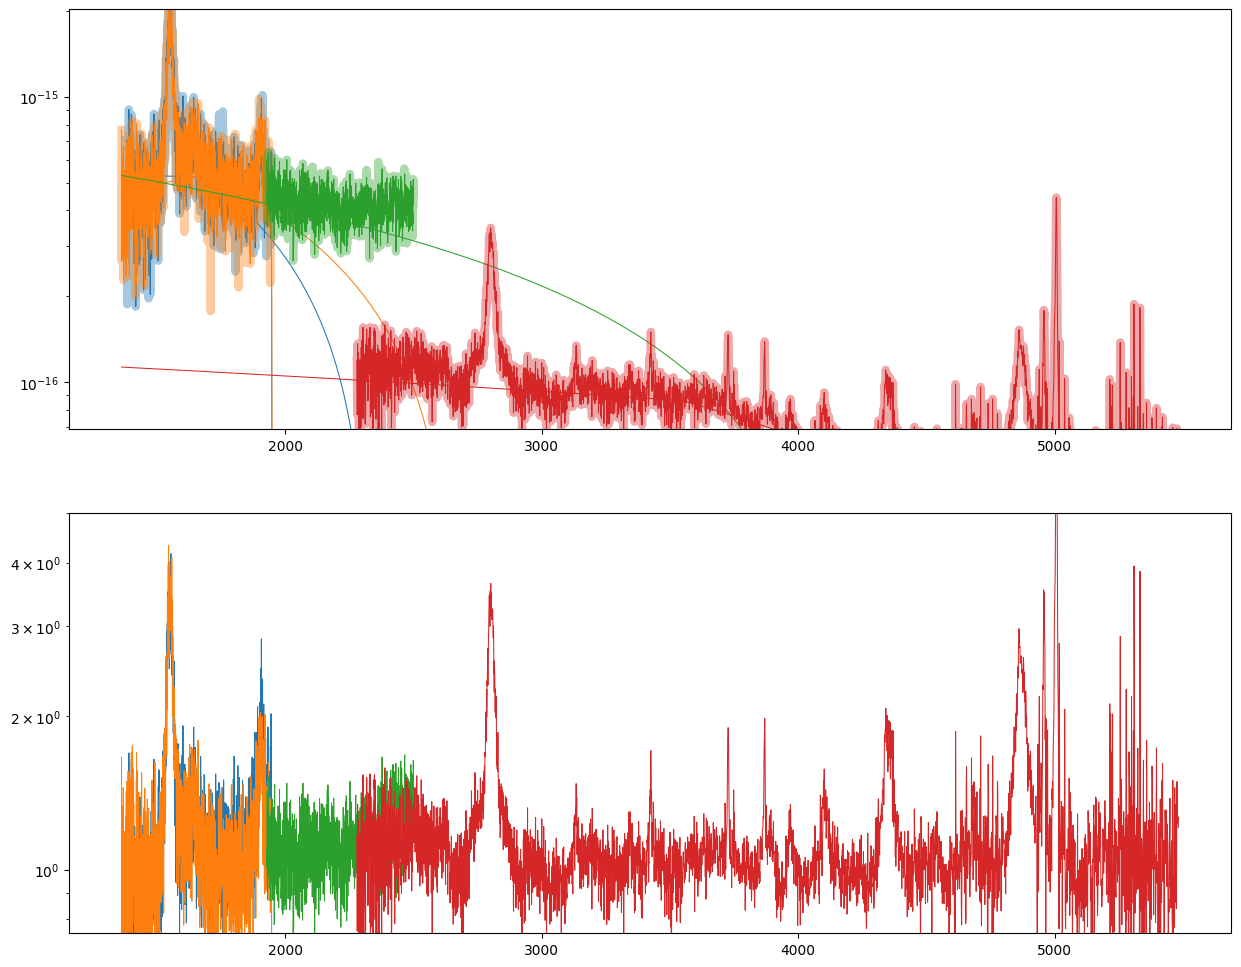

In [168]:
fluxes_rebin_contnorm = fluxes_rebin.copy()
errors_rebin_contnorm = errors_rebin.copy()

fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(15,12))
ylow, yup = np.nanpercentile(fluxes_rebin, [15,99.9])
for i in range(Nexp):
    p = ax1.plot(waves[i,:]/(1+zem), fluxes[i,:], alpha=0.4, lw=6)
    #print(p[0])
    # From what I can tell, p is used for the fuzzy border around the flux data. Used for color and border but nothing else. 

    ax1.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], color=p[0].get_color(), lw=0.75)
    #ax1.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], lw=0.75)
    print(p[0].get_color())
    #continuum = spec_morph.cont_filtered(10.**loglam_rebin[i,:], fluxes_rebin[i,:], zem, "Identifier")
    markers = [1145,1290,1450,1690,1810,1985,2200,2400,2660,2915,3550,4200,4720,5150,6125,6850,7000]
    markers = [1145,1290, 1325, 1450,1690,1810,1985,2200,2660,2915,3550,4200,4720,5150,6125,6850,7000]
    continuum = spec_morph.continuum_fit(10.**loglam_rebin[i,:], fluxes_rebin[i,:], zem, 5, markers)
    
    ax1.plot(10.**loglam_rebin[i,:]/(1+zem), continuum, color=p[0].get_color(), lw=0.75) # Here we plot the actual continuum line. What is different?
    
    ax2.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:]/continuum, color=p[0].get_color(), lw=0.75)
    fluxes_rebin_contnorm[i,:] = fluxes_rebin[i,:] / continuum
    errors_rebin_contnorm[i,:] = errors_rebin[i,:] / continuum
    
#do SDSS now
#spec_continuum = spec_morph.continuum_fit2(spec_wave, spec_flux, zem)
#ax1.plot(spec_wave/(1+zem), spec_flux, "-b")
#ax2.plot(spec_wave/(1+zem), spec_flux/spec_continuum, "-b")
    
ax1.set_ylim(ylow, yup)
#ax1.set_ylim(5e-16,2.5e-15)
ax2.set_ylim(0.75,5)
#ax1.set_xlim(2250,None)
ax1.set_yscale("log")
ax2.set_yscale("log")
plt.savefig('New Rebin Morph Coadd.png', bbox_inches = 'tight')
plt.show()

In [54]:
filename

'spec-2426-53795-0625.fits'

In [113]:
fluxes_rebin[6]

IndexError: index 6 is out of bounds for axis 0 with size 6

In [112]:
plt.plot(10.**loglam_rebin[0,:]/(1+zem), fluxes_rebin[6,:])

IndexError: index 6 is out of bounds for axis 0 with size 6

In [114]:
Nexp

6

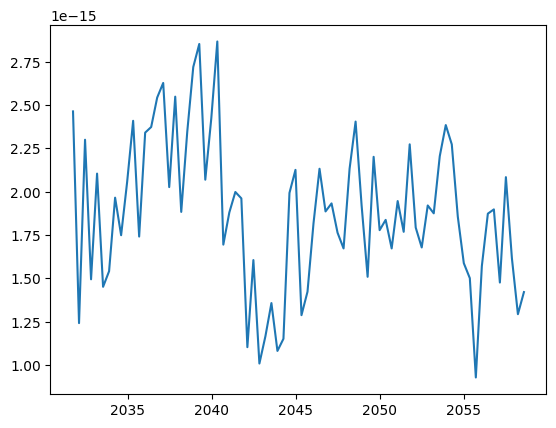

In [130]:
plt.plot(hst_waves[0], hst_fluxes[0])

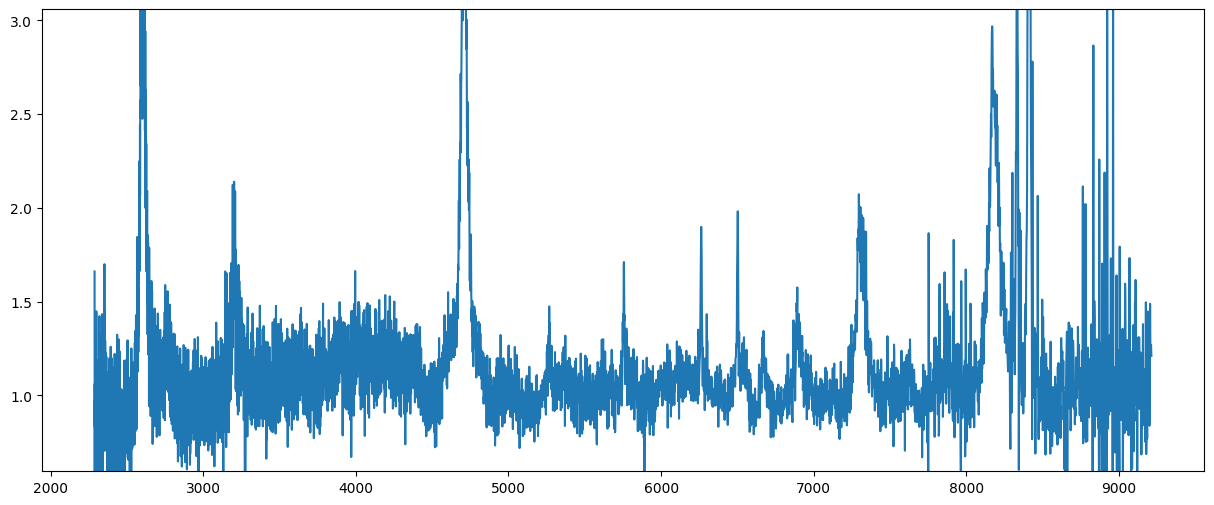

In [169]:
coadd_wave = 10.**loglam_temp.copy()
coadd_flux = np.zeros(len(coadd_wave))*np.nan
coadd_errs = np.zeros(len(coadd_wave))*np.nan
coadd_mask = np.zeros(len(coadd_wave))

total_variance = np.nansum(errors_rebin, axis=0)

weights = 1 / (errors_rebin / total_variance)

weights[(np.isnan(weights))|(np.isinf(weights))] = 0

for i in range(len(coadd_wave)):
    coadd_flux[i] = ws.numpy_weighted_median(fluxes_rebin_contnorm[:,i], weights=weights[:,i])
    coadd_errs[i] = ws.numpy_weighted_median(errors_rebin_contnorm[:,i], weights=weights[:,i])
    coadd_mask[i] = np.nanmin(masks_rebin[:,i])

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(coadd_wave, coadd_flux)
ax.set_ylim(np.nanpercentile(coadd_flux, [1,99]))
plt.show()

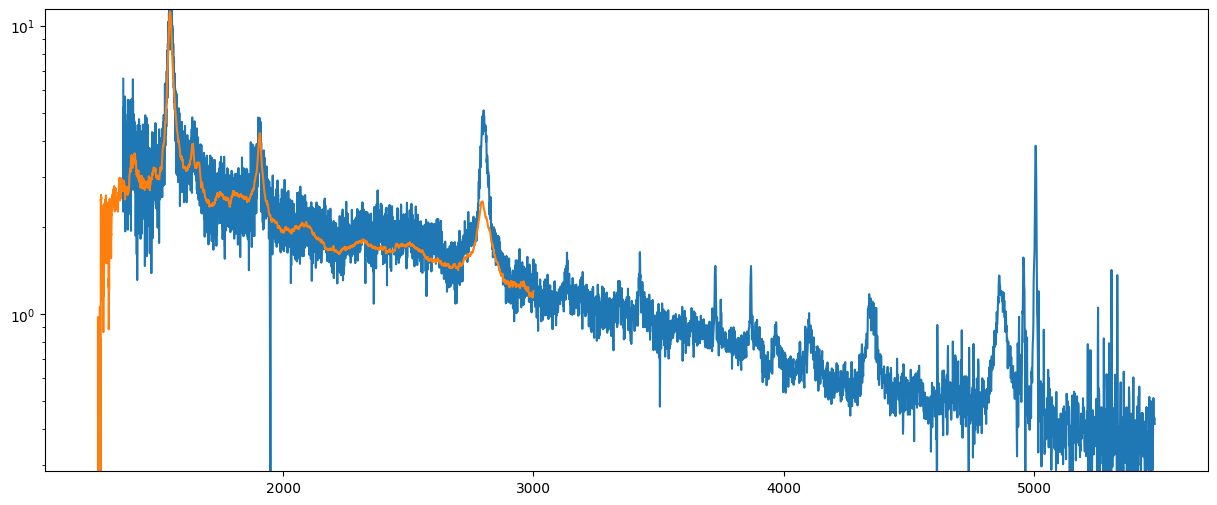

In [170]:
wave_arb, flux_arb, errs_arb, mask_arb, wave_ica, flux_ica, f2500_ica = \
run_ICA_r20_components.main_ICA(coadd_wave/(1+zem), coadd_flux, coadd_errs, coadd_mask, zem, name="", 
                                ica_path="./")

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(wave_arb, flux_arb)
ax.plot(wave_ica, flux_ica)
ax.set_ylim(np.nanpercentile(flux_arb, [.7,99.9]))
ax.set_yscale("log")
plt.show()

In [171]:
def plot_wmask(ax, wave, flux, mask):
    iplot_start = 0
    #iplot_end   = 0
    mask_curr   = mask_arb[0]
    for i in range(len(wave_arb)):
        #go until mask is a different value
        if mask_arb[i]!=mask_curr or i==len(wave_arb)-1:
            if mask_curr==3:
                #plot BAL region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-m", zorder=2)
            elif mask_curr==2:
                #plot NAL region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-y", zorder=2)
            elif mask_curr==1:
                #plot badpix region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-r", zorder=2)
            else:
                #plot BAL region
                ax.plot(wave_arb[iplot_start:i], flux_arb[iplot_start:i], "-k", zorder=1)

            mask_curr = mask_arb[i]
            iplot_start = i-1

C:\Users\Alexandros Pratsos\AppData\Local\Temp\ipykernel_20316\2453525723.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


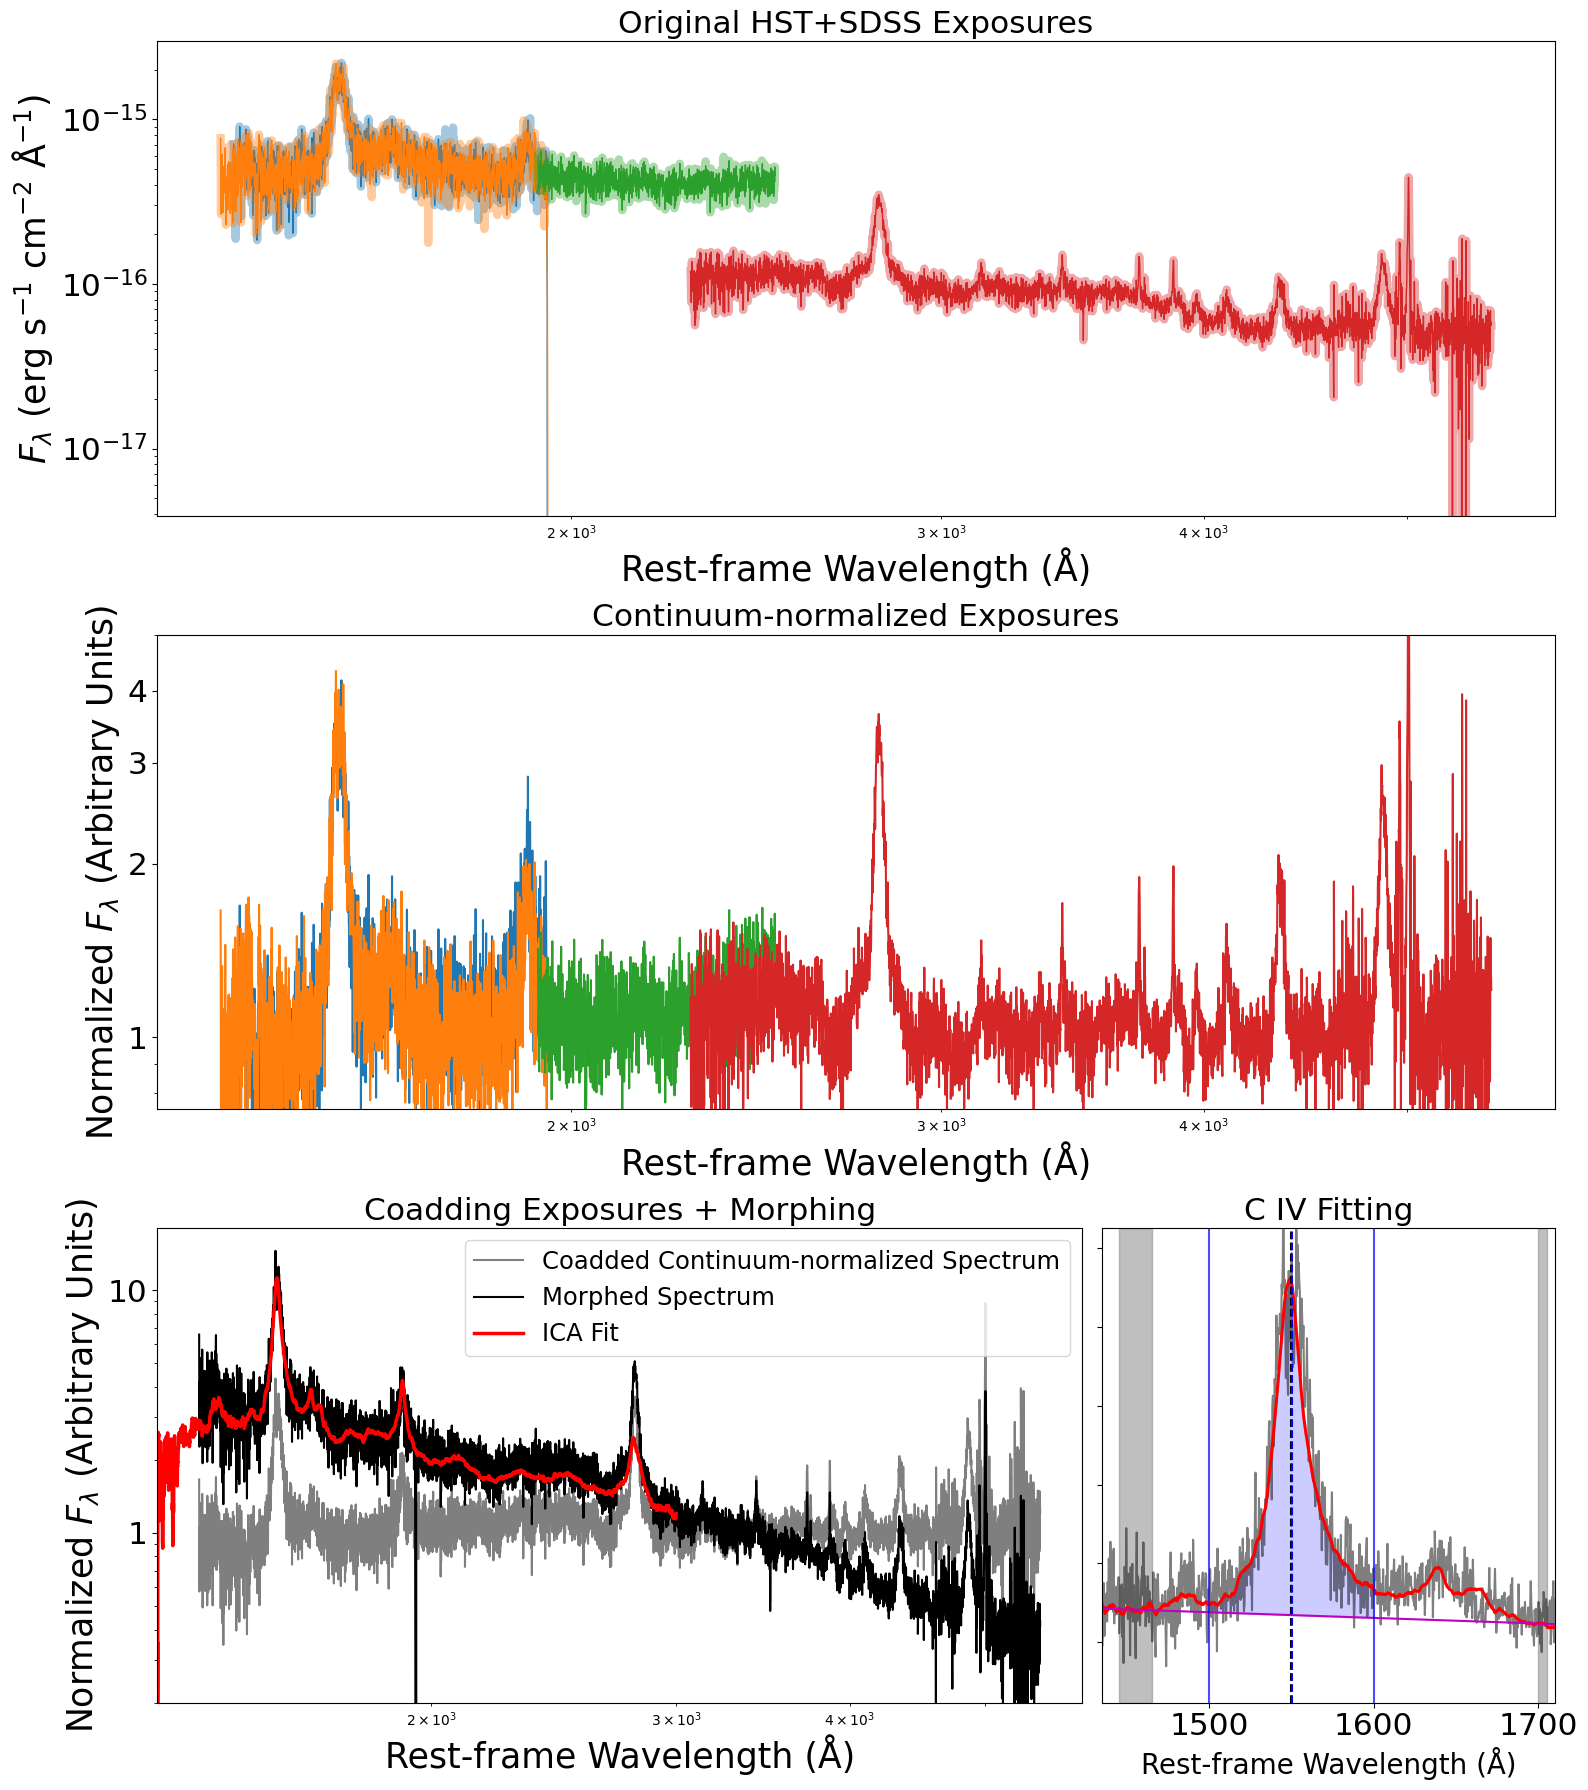

In [175]:
#fig, [axRebin, axNorm, axMorph] = plt.subplots(3, 1, figsize=(16,17))
fig = plt.figure(figsize=(16,18), constrained_layout=True)
gs  = GridSpec(12, 12, figure=fig)
axRebin = fig.add_subplot(gs[:4,:]) #ica reconstruction
axNorm  = fig.add_subplot(gs[4:8,:])   #CIV fitting
axMorph = fig.add_subplot(gs[8:,:8])
axCIV   = fig.add_subplot(gs[8:,8:])
#plt.subplots_adjust(vspace=0)

#do re-bin
ylow, yup = np.nanpercentile(fluxes_rebin, [1,100])
for i in range(Nexp):
    p = axRebin.plot(waves[i,:]/(1+zem), fluxes[i,:], alpha=0.4, lw=6)
    axRebin.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin[i,:], color=p[0].get_color(), lw=1)
    #axRebin.plot(10.**loglam_rebin[i,:]/(1+zem), errors_rebin[i,:], color=p[0].get_color(), lw=0.75)
    axNorm.plot(10.**loglam_rebin[i,:]/(1+zem), fluxes_rebin_contnorm[i,:], color=p[0].get_color())

#axRebin.plot(spec_wave/(1+zem), spec_flux, "-b")
#axRebin.set_ylim(ylow, yup+5e-15)
#ylow2, yup2 = np.nanpercentile(fluxes_rebin, [1,100])
#axRebin.set_ylim(ylow2, yup2)
#axRebin.set_ylim(2e-17, yup)
axRebin.set_yscale("log")
axRebin.set_xscale("log")
#set_logxticks(axRebin, waves[waves!=0]/(1+zem))
axRebin.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)
axRebin.set_ylabel(r"$F_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)", fontsize=25)

#axNorm.plot(coadd_wave/(1+zem), coadd_flux, "-k", lw=0.65)
axNorm.set_ylim(0.75,5)
axNorm.set_yscale("log")
axNorm.set_yticks([1,2,3,4])
axNorm.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axNorm.set_xscale("log")
#set_logxticks(axNorm, waves[waves!=0]/(1+zem))
axNorm.set_xlim(axRebin.get_xlim())
axNorm.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
axNorm.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)

#morph flux
flux_coadd_morph, _ = spec_morph.morph2(coadd_wave, coadd_flux, coadd_errs, zem, "Identifier")
axMorph.plot(coadd_wave/(1+zem), coadd_flux, "-k", alpha=0.5, label="Coadded Continuum-normalized Spectrum")
axMorph.plot(coadd_wave/(1+zem), flux_coadd_morph, "-k", label="Morphed Spectrum")
axMorph.plot(wave_ica, flux_ica, "-r", lw=2.5, label="ICA Fit")
axMorph.set_ylim(0.2,18)
axMorph.set_yscale("log")
axMorph.set_yticks([1,10])
axMorph.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axMorph.set_xscale("log")
#set_logxticks(axMorph, waves[waves!=0]/(1+zem))
axMorph.set_xlim(axRebin.get_xlim())
axMorph.set_xlabel("Rest-frame Wavelength (Å)", fontsize=25)
axMorph.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
axMorph.legend(loc="upper right", prop={"size":17.5})

get_CIV(coadd_wave/(1+zem), flux_coadd_morph, wave_ica, flux_ica, "", ax=axCIV)

"""
plot_wmask(axICA, wave_arb, flux_arb, mask_arb)
#axICA.plot(wave_arb, errs_arb, "-k", alpha=0.4)
axICA.plot(wave_ica, flux_ica, "-r")
axICA.set_ylim(0.2,15)
axICA.set_yscale("log")
axMorph.set_yticks([1,10])
axMorph.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axMorph.set_xscale("log")
set_logxticks(axMorph, waves[waves!=0]/(1+zem))
axMorph.set_xlim(axRebin.get_xlim())
axMorph.set_ylabel(r"Normalized $F_{\lambda}$ (Arbitrary Units)", fontsize=25)
"""

axRebin.tick_params(labelsize=22.5)
axNorm.tick_params(labelsize=22.5)
axMorph.tick_params(labelsize=22.5)
axCIV.tick_params(labelsize=22.5)

axRebin.set_title("Original HST+SDSS Exposures", fontsize=22.5)
axNorm.set_title("Continuum-normalized Exposures", fontsize=22.5)
axMorph.set_title("Coadding Exposures + Morphing", fontsize=22.5)
axCIV.set_title("C IV Fitting", fontsize=22.5)

plt.tight_layout()
#plt.savefig("/Users/trevormccaffrey/Dropbox/HST/final_MarchApril2023/examples_fullprocess_J09270.pdf")
plt.show()